In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.image as mpimg
import cv2
from CNNsig import sigGF, sigG
from batch_wrapper import batch_dataset
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs

from pandas.tools.plotting import parallel_coordinates
from data_preprocessing import print_arr

In [2]:
DATA_DIR = './data/'

In [ ]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))

In [34]:
def make_user_image(directory):
    
    imgs = nested_dict(2, np.array) # 3 dimension
    files = [f for f in os.listdir(directory)]
    for f in files:
        fs = f.split("_")
        img = cv2.imread(directory+f)
        uid = int(fs[1][1:]) # user id
        iid = int(fs[2]) # image id
        sid = int(fs[3])
        t = int(fs[4][:-4])
        if sid == 0:
            img_ = img
            ts = t
        else:
            img_ += img
            ts += t
        
        imgs[uid][iid] = np.array([img_, ts])
    return imgs

In [35]:
images = make_user_image(DATA_DIR)

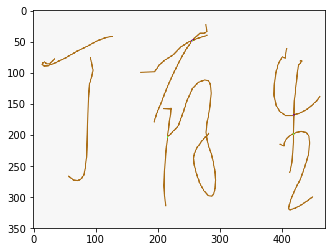

In [42]:
print_arr(images[1][15][0])

In [77]:
imgs = []; uids=[]; is_fs=[];
for u in images.keys():
    image = images[u]
    for i in image.keys():
        imgs.append(image[i][0])
        uids.append(u-1)
        if i < 21:
            is_fs.append(0)
        else:
            is_fs.append(1)

imgs = np.array(imgs)
uids = np.array(uids)
is_fs = np.array(is_fs)

Training Model Setting

In [78]:
img_shape = imgs[0].shape
num_person = len(np.unique(uids))
print ("The shape of image: ", img_shape)
print ("The number of persons: ", num_person)

The shape of image:  (350, 470, 3)
The number of persons:  40


In [79]:
Y_uid = np.eye(num_person)[uids]
Y_isF = np.eye(2)[is_fs.astype(np.uint8)]

# Shuffle input and output data
# idx = np.arange(len(imgs))
# np.random.shuffle(idx)
# shuffled_X = np.array(imgs[idx])
# shuffled_Y_M = np.array(Y_uid[idx])
# shuffled_Y_D = np.array(Y_isF[idx])

In [80]:
GF_model = sigGF(img_shape, num_person)

In [84]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 30
total_batch = int(len(imgs) / batch_size)
print ("batch num = %d" % total_batch)

batch num = 53


In [85]:
batch_X = batch_dataset(imgs, batch_size)
batch_Y_M = batch_dataset(Y_uid, batch_size)
batch_Y_D = batch_dataset(Y_isF, batch_size)

In [86]:
for epoch in range(10):
    total_cost_M = 0
    total_cost_D = 0
    
    for i in range(total_batch):
        batch_x = batch_X.next_batch()
        batch_y_m = batch_Y_M.next_batch()
        batch_y_d = batch_Y_D.next_batch()
        _, cost_M_val,cost_D_val = GF_model.train(sess, batch_x, batch_y_m, batch_y_d)
        total_cost_M += cost_M_val
        total_cost_D += cost_D_val
    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost_M =', '{:.3f}'.format(total_cost_M / total_batch),
          'Avg. cost_D =', '{:.3f}'.format(total_cost_D / total_batch))

print('최적화 완료!')

Epoch: 0001 Avg. cost_M = 5.055 Avg. cost_D = 1.200
Epoch: 0002 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0003 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0004 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0005 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0006 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0007 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0008 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0009 Avg. cost_M = 3.691 Avg. cost_D = 0.693
Epoch: 0010 Avg. cost_M = 3.691 Avg. cost_D = 0.693
최적화 완료!


In [87]:
GF_model.saver.save(sess, "./save/train_withF_nontrainable",11)

'./save/train_withF_nontrainable-11'

Save features from the last layers from CNN

In [3]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

img_shape = (350, 470, 3)
num_person = 40
GF_model = sigGF(img_shape, num_person)
GF_model.saver.restore(sess, "./save/train_withF_nontrainable-11")

INFO:tensorflow:Restoring parameters from ./save/train_withF_nontrainable-11


In [100]:
encoded_X = GF_model.get_feature(sess, imgs[:1])

In [4]:
def load_image_details(directory):
    files = [f for f in os.listdir(directory)]
    imgs=[]; uids=[]; is_fs=[]; sids=[]; ts=[]; features = [];
    for f in files:
        fs = f.split("_")
        img = cv2.imread(directory+f)
        uid = int(fs[1][1:])-1 # user id
        iid = int(fs[2])-1 # image id
        sid = int(fs[3])
        t = int(fs[4][:-4])
        
        imgs.append(img); uids.append(uid);
        if iid < 21: is_fs.append(0)
        else:        is_fs.append(1)
        ts.append(t); sids.append(sid)
        features.append(GF_model.get_feature(sess, img.reshape(1, 350, 470, 3)))
        
    return np.array(imgs), np.array(uids), np.array(is_fs), \
        np.array(sids), np.array(ts), np.array(features)

imgs, uids, is_fs, sids, ts, features = load_image_details(DATA_DIR)

# RNN Part

In [466]:
cnt = 0
cnts = list()
for sid in sids:
    if sid == 0:
        cnts.append(cnt)
        cnt = 0
    cnt += 1
cnts.append(cnt)
cnts = cnts[1:]
print ("The maximum of strokes: ", min(cnts))
print ("The maximum of strokes: ", max(cnts))

The maximum of strokes:  1
The maximum of strokes:  18


In [493]:
super_features = []
super_uids = []
idx = 0
for cnt in cnts:
    super_features.append(features[idx: idx+cnt].reshape(cnt,256))
    super_uids.append(uids[idx: idx+cnt].reshape(cnt,))
    idx += cnt
super_features = np.array(super_features)
super_uids = np.array(super_uids)
super_cnts = np.array(cnts)

In [494]:
# Shuffling 
idx = np.arange(len(super_features))
np.random.seed(0)
np.random.shuffle(idx)
shuffled_features = np.array(super_features[idx])
shuffled_uids = np.array(super_uids[idx])
shuffled_cnts = np.array(super_cnts[idx])

In [471]:
max_step = 18
n_input = 256
n_hidden = 256
n_class = 40
batch_size = 32

In [472]:
tf.reset_default_graph()

In [473]:
X = tf.placeholder(tf.float32, [None, None, n_input])
seq_len = tf.placeholder(tf.int32, [None])
Y = tf.placeholder(tf.int32, [None])

W = tf.Variable(tf.random_normal([n_hidden, n_class]))
b = tf.Variable(tf.random_normal([n_class]))

In [474]:
cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, sequence_length=seq_len)

outputs = tf.transpose(outputs, [1, 0, 2])
outputs = outputs[-1]

model = tf.matmul(outputs, W) + b
preds = tf.nn.softmax(model)

In [475]:
is_correct = tf.equal(tf.cast(tf.argmax(preds, 1), tf.int32), Y)
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [476]:
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)

In [477]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())        

In [508]:
class batch_dataset:
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
        self.cnt_idx = 0
    
    def next_batch(self, cnt, batch_size):
        batch_xs = []; batch_ys = [];
        for i in range(self.cnt_idx, self.cnt_idx + batch_size):
            batch_xs.append(self.xs[i])
            batch_ys.append(self.ys[i][0])
        self.cnt_idx += batch_size
        return np.array(batch_xs), np.array(batch_ys)

In [509]:
batch_size = 32
total_batch = int(len(cnts) / batch_size)

for epoch in range(10):
    total_cost = 0
    
    batcher = batch_dataset(shuffled_features, shuffled_uids)
    for cnt in shuffled_cnts:
        xs, ys = batcher.next_batch(cnt, 1)
        lens = np.array([cnt])

        feed = {seq_len: lens, X: xs, Y: ys}
        _, cost_val = sess.run([optimizer, cost], feed)
        total_cost += cost_val
    
    print ("Epoch: ", "%04d" % (epoch+1),
           "Average cost = ", "{:.3f}".format(total_cost / len(shuffled_cnts)))

Epoch:  0001 Average cost =  3.700
Epoch:  0002 Average cost =  3.133
Epoch:  0003 Average cost =  2.919
Epoch:  0004 Average cost =  2.763
Epoch:  0005 Average cost =  2.628
Epoch:  0006 Average cost =  2.505
Epoch:  0007 Average cost =  2.391
Epoch:  0008 Average cost =  2.279
Epoch:  0009 Average cost =  2.163
Epoch:  0010 Average cost =  2.034


In [510]:
saver = tf.train.Saver(tf.global_variables())
saver.save(sess, "./save/rnn_part", 11)

'./save/rnn_part-11'

In [517]:
batcher = batch_dataset(features, uids)
t_val = 0

batcher = batch_dataset(shuffled_features, shuffled_uids)
for cnt in shuffled_cnts[:500]:
    xs, ys = batcher.next_batch(cnt, 1)
    lens = np.array([cnt])

    is_correct = tf.equal(tf.argmax(model, 1), ys[0])
    a = sess.run([accuracy], feed_dict={seq_len: lens, X: xs, Y: ys})
    t_val += a[0]

print (t_val / 500)

0.418


In [ ]:
print (t_val)